# Canadian House Market Prediction

## Data Loading

In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('datasets/realtordataUS.csv', encoding='UTF-8')

""" df['target'] = df['species'].replace({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}) """

df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


### Null/Missing values Check

In [33]:
print(df.isnull().sum())

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64


### Statistics of Dataset

In [34]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


### Data Preproccessing

First we will drop all null values present in the dataset since there are tons from the Null Value Check

In [35]:
df = df.dropna().drop(columns=["brokered_by", "status", "prev_sold_date", "street"])

# Display the cleaned DataFrame
print(df)

             price  bed  bath  acre_lot          city           state  \
502       110000.0  7.0   3.0      0.09        Dorado     Puerto Rico   
2270      950000.0  5.0   4.0      0.99  Saint Thomas  Virgin Islands   
2277     6899000.0  4.0   6.0      0.83  Saint Thomas  Virgin Islands   
3409      525000.0  3.0   3.0      0.45        Agawam   Massachusetts   
3410      289900.0  3.0   2.0      0.36        Agawam   Massachusetts   
...            ...  ...   ...       ...           ...             ...   
2226377   359900.0  4.0   2.0      0.33      Richland      Washington   
2226378   350000.0  3.0   2.0      0.10      Richland      Washington   
2226379   440000.0  6.0   3.0      0.50      Richland      Washington   
2226380   179900.0  2.0   1.0      0.09      Richland      Washington   
2226381   580000.0  5.0   3.0      0.31      Richland      Washington   

         zip_code  house_size  
502         949.0      1192.0  
2270        802.0      5000.0  
2277        802.0      4600

We also want to drop all duplicate rows if there are any.

In [36]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print(df)


             price  bed  bath  acre_lot          city           state  \
0         110000.0  7.0   3.0      0.09        Dorado     Puerto Rico   
1         950000.0  5.0   4.0      0.99  Saint Thomas  Virgin Islands   
2        6899000.0  4.0   6.0      0.83  Saint Thomas  Virgin Islands   
3         525000.0  3.0   3.0      0.45        Agawam   Massachusetts   
4         289900.0  3.0   2.0      0.36        Agawam   Massachusetts   
...            ...  ...   ...       ...           ...             ...   
1011647   359900.0  4.0   2.0      0.33      Richland      Washington   
1011648   350000.0  3.0   2.0      0.10      Richland      Washington   
1011649   440000.0  6.0   3.0      0.50      Richland      Washington   
1011650   179900.0  2.0   1.0      0.09      Richland      Washington   
1011651   580000.0  5.0   3.0      0.31      Richland      Washington   

         zip_code  house_size  
0           949.0      1192.0  
1           802.0      5000.0  
2           802.0      4600

Then we can start to encode any categorical values to unique numerical values. This includes province, and city categories.

In [37]:
# Integer encoding all categorical variables
city_mapping = {city: idx for idx, city in enumerate(df['city'].unique())}
state_mapping = {state: idx for idx, state in enumerate(df['state'].unique())}
zip_mapping = {zipp: idx for idx, zipp in enumerate(df['zip_code'].unique())}
df['city'] = df['city'].map(city_mapping)
df['state'] = df['state'].map(state_mapping)
df['zip_code'] = df['zip_code'].map(zip_mapping)

print(df)


             price  bed  bath  acre_lot  city  state  zip_code  house_size
0         110000.0  7.0   3.0      0.09     0      0         0      1192.0
1         950000.0  5.0   4.0      0.99     1      1         1      5000.0
2        6899000.0  4.0   6.0      0.83     1      1         1      4600.0
3         525000.0  3.0   3.0      0.45     2      2         2      2314.0
4         289900.0  3.0   2.0      0.36     2      2         2      1276.0
...            ...  ...   ...       ...   ...    ...       ...         ...
1011647   359900.0  4.0   2.0      0.33  1697     46     22030      3600.0
1011648   350000.0  3.0   2.0      0.10  1697     46     22030      1616.0
1011649   440000.0  6.0   3.0      0.50  1697     46     22030      3200.0
1011650   179900.0  2.0   1.0      0.09  1697     46     22030       933.0
1011651   580000.0  5.0   3.0      0.31  1697     46     22030      3615.0

[1011652 rows x 8 columns]


We also should normalize our numeric features because the values range vastly across the dataset. This will ensure our data is on similar scales and this could improve our models performance down the line. We will perform this on 

In [38]:
#Normalize numerical features
numerical_features = ['acre_lot', 'house_size']
feature_mean = df[numerical_features].mean()
feature_std = df[numerical_features].std()

df[numerical_features] = (df[numerical_features] - feature_mean) / feature_std

Now we need to seperate features as well as targets in order to utilize PyTorch. So we complete the following:

In [39]:
#Separate features and target
X = df.drop(columns=['price'])
y = df['price']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Create TensorDataset and DataLoaders
dataset = TensorDataset(X_tensor, y_tensor)


Finally we can split the data into training and testing sets, and we can prepare a dataloader. This ensures we can use batching which will also help performance.

In [40]:
# Split into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data preparation complete! Ready for modeling.")

Data preparation complete! Ready for modeling.


## Visualization & Exploratory Data Analysis

Lets first see count of all priced houses. If we do it regularly its incredibly difficult to see due to the outliers and they dominate the scale of our plot. We can then use a logarithmic scale to further see the relationships.

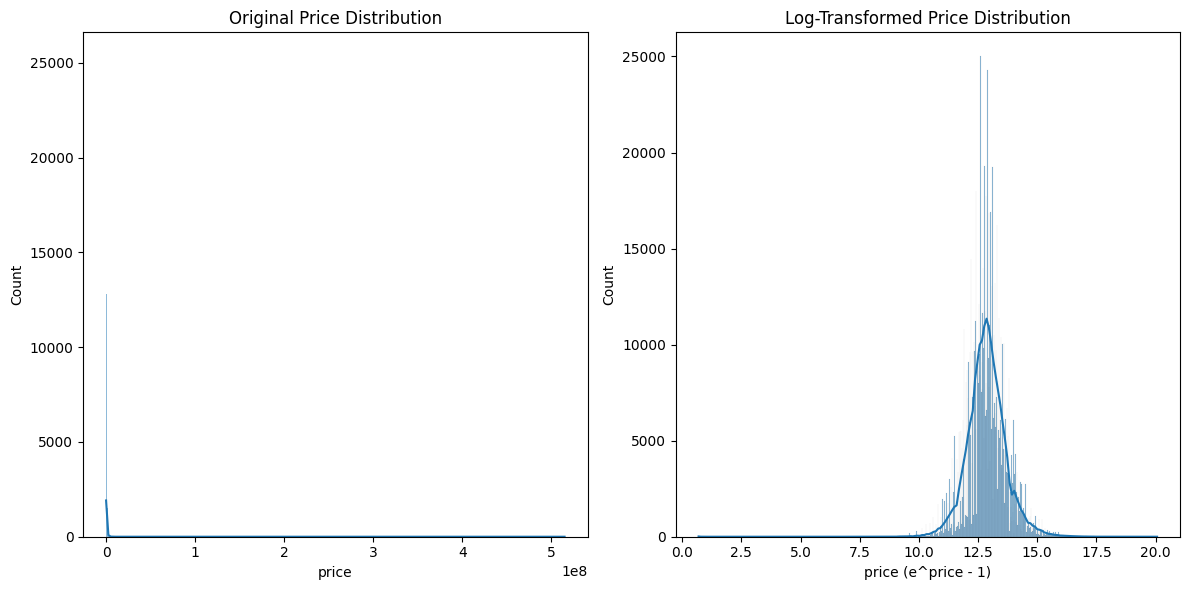

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation to Price
temp = np.log1p(df['price'])  # log1p handles log(1 + x), avoiding log(0)

# Visualize the original and transformed distributions
plt.figure(figsize=(12, 6))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Original Price Distribution')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(temp, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel("price (e^price - 1)")

plt.tight_layout()
plt.show()

We can also plot this to a heatmap to show the correlation matrix of all features that are numerical.

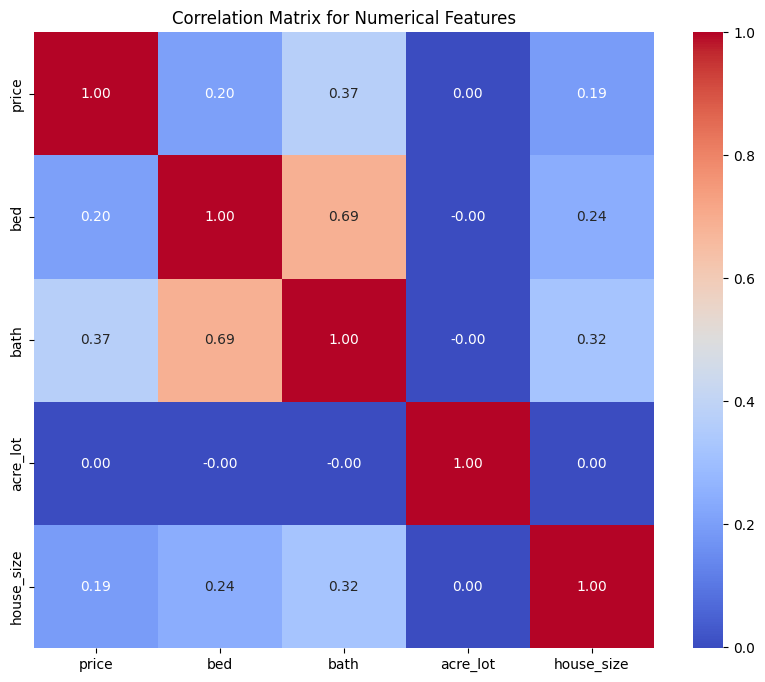

In [44]:
# Compute the correlation matrix
corr_columns = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
corr_matrix = df[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix for Numerical Features')
plt.show()

Here is the correlation graphings and the pairplots for all features as well. These are also log-scaled due to the extreme outlier situation we faced earlier.

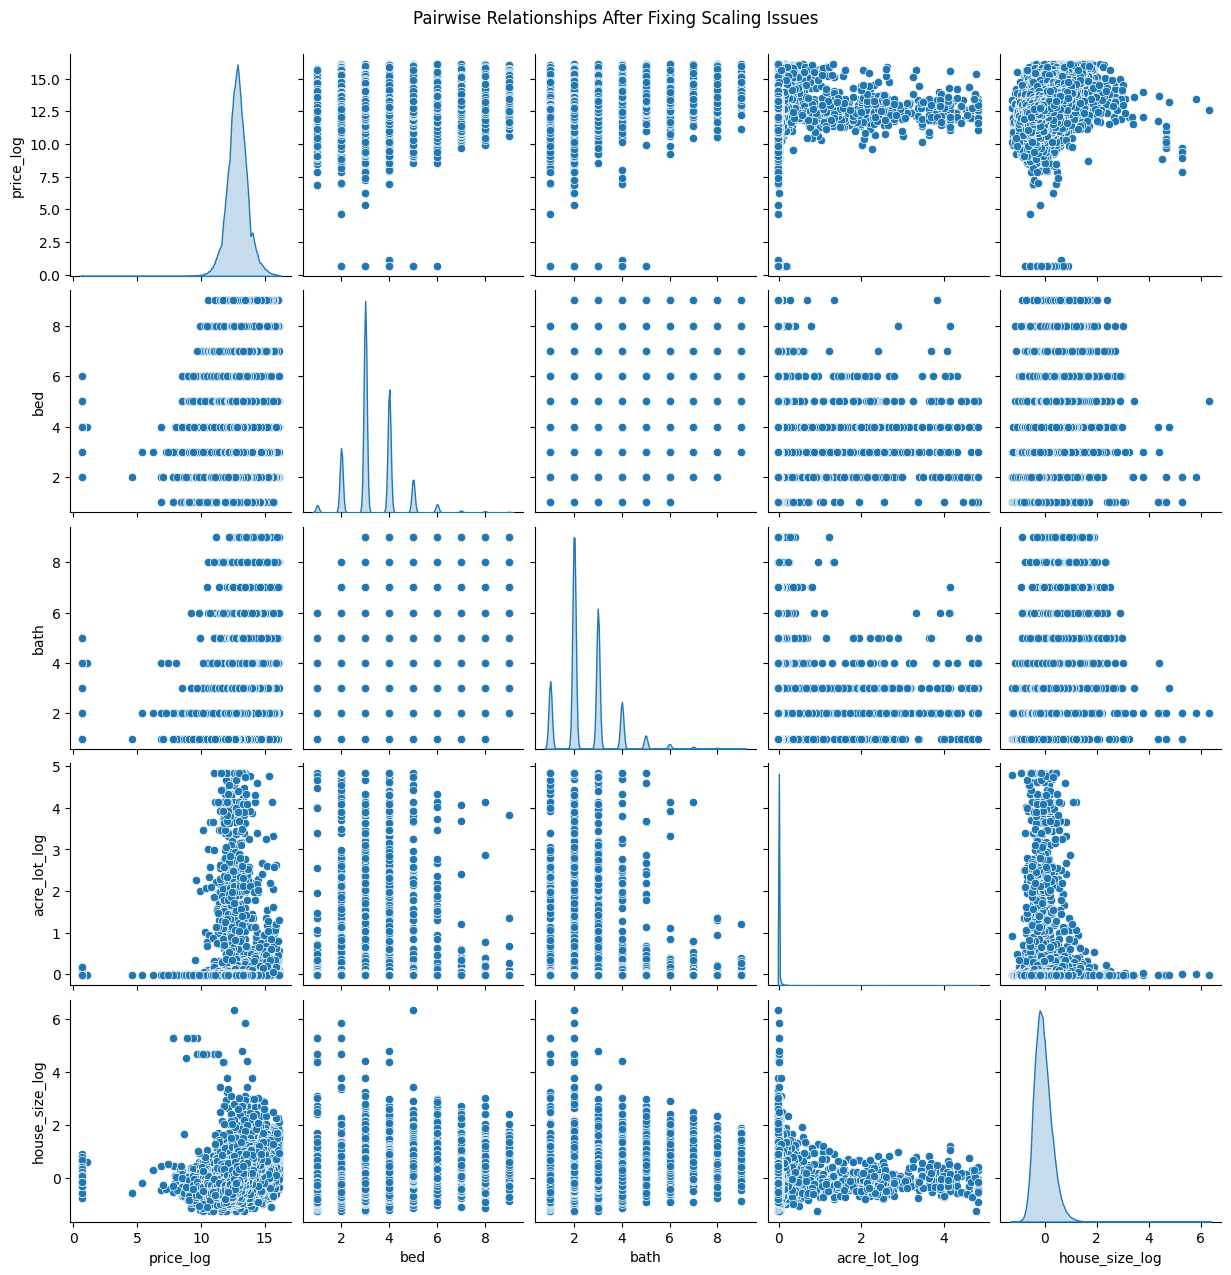

In [ ]:
# Apply Log to handle scaling issues
df['price_log'] = np.log1p(df['price'])
df['house_size_log'] = np.log1p(df['house_size'])
df['acre_lot_log'] = np.log1p(df['acre_lot'])

#Filter extreme outliers for visualization (optional, not affecting the dataset)
filtered_df = df[
    (df['price'] < 1e7) & 
    (df['bed'] < 10) & 
    (df['bath'] < 10) & 
    (df['house_size'] < 5000)
]

# Generate pairplot with filtered data
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    filtered_df, 
    vars=['price_log', 'bed', 'bath', 'acre_lot_log', 'house_size_log'], 
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships After Fixing Scaling Issues', y=1.02)
plt.show()


In [3]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, shuffle=True, batch_size=4)

In [4]:
torch.manual_seed(4050)
batch0 = next(iter(dataloader))
batch0

[tensor([[6.7000, 3.1000, 4.4000, 1.4000],
         [4.8000, 3.1000, 1.6000, 0.2000],
         [6.7000, 2.5000, 5.8000, 1.8000],
         [4.5000, 2.3000, 1.3000, 0.3000]]),
 tensor([1, 0, 2, 0])]

In [5]:
import torchmetrics

def evaluate(model):
    accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=3)
    x, y_exp = dataset[:]
    y = model(x)
    return accuracy(y, y_exp)

In [6]:
import lightning as L   # torch lightning
import torchinfo        # torch info
from torch import nn    # neural network layers
from torch import optim # optimizers

In [7]:
class LinearClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        # define the `nn` as the neural network. In this case, it
        # should be a simple nn.Linear(...) layer.
        self.nn = nn.Linear(4, 3)
        
        # define the loss function to be used.
        # It should be nn.CrossEntropyLoss(...)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, batch):
        # return the output which should be
        # a 3D vector corresponding to the logits of the
        # three class predictions.
        return self.nn(batch)
    
    def training_step(self, batch):
        # - The batch is a tuple (x, targets), where
        #   x is the input vectors, and targets the integer labels.
        # - return the loss value for the current batch.
        # - the loss is computed using forward(...) and loss_fn(...)
        x, targets = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, targets)
        return loss
    
    def configure_optimizers(self):
        # returns an optimizer that is configured to
        # optimize `self.parameters()`.
        # Use the optim.Adam(...)
        return optim.Adam(self.parameters(), lr=0.01)

In [8]:
class MLP(LinearClassifier):
    def __init__(self, hidden:int):
        super().__init__()
        self.nn = nn.Sequential(
            # linear layer
            nn.Linear(4, hidden),
            # ReLU
            nn.ReLU(),
            # output linear layer
            nn.Linear(hidden, 3)
        )

In [9]:
torchinfo.summary(MLP(10))

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       50
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33
├─CrossEntropyLoss: 1-2                  --
Total params: 83
Trainable params: 83
Non-trainable params: 0

In [10]:
torch.manual_seed(0)
model = MLP(10)
trainer = L.Trainer(max_epochs=10)

trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | nn      | Sequential       | 83     | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
83        Trainable params
0         Non-trainable params
83        Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 38/38 [00:00<00:00, 400.00it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 38/38 [00:00<00:00, 376.24it/s, v_num=7]


In [11]:
evaluate(model)

tensor(0.9533)

In [12]:
import onnx

model.eval()
torch.onnx.export(
    model,
    torch.randn(1, 4),
    "../deploy/my_model.onnx",
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)